In [1]:
# pip install --upgrade tensorflow
%matplotlib inline
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# !pip install tensorflow
# !pip install keras_tuner

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

lw = 1 # line weight for plt
BATCH_SIZE = 32 # Model batch size
EPOCHS = 100 # Model number of epoch 
MODELS_RESULTS={} # store for all model result for both balanced and resampled datasets
n_classes=10
num_columns = 42  # Number of columns in df
regularizers=tf.keras.regularizers.l2(0.001)
print(tf.__version__)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

2.7.0


In [3]:
# importing the train and test data dataset from file
train_val_csv = pd.read_csv('./data/UNSW_NB15_training-set.csv')
test_csv = pd.read_csv('./data/UNSW_NB15_testing-set.csv')

In [4]:
train_val=train_val_csv.drop(columns=['id','label'])
test=test_csv.drop(columns=['id','label'])

In [5]:
# Split the data into train and test with 80 train / 20 test
train,val = train_test_split(train_val, test_size=0.2, random_state = 1)

In [6]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65865 training examples
16467 validation examples
175341 test examples


In [7]:
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
print(CLASSES)
# # five metrics used for evaluation process
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [8]:
def plot_chart(history,name):
    plt.figure(figsize=(10, 10))
    names =['loss','accuracy']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

In [9]:
def group_by_data_type(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result

In [10]:
# convert dataprame to tensore datasets
def dataframe_to_dataset_multi_feature(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [11]:
train_df = train.copy();
val_df = val.copy();
test_df = test.copy();

In [12]:
# seperate the structured data into individal type
data_types = group_by_data_type(train_df) # return result from
number_col=data_types['number_col']
string_category_col=data_types['string_category_col']
int_category_col=data_types['int_category_col']

In [13]:
print('numbers column', number_col)
print('_________________________________________________')
print('string column',string_category_col)
print('_________________________________________________')
print('integer column',int_category_col)

numbers column ['dur', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat']
_________________________________________________
string column ['proto', 'service', 'state']
_________________________________________________
integer column ['spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'swin', 'stcpb', 'dtcpb', 'dwin', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


In [14]:
# ensure all preprosesing  layer adapt to the structure of the dataset 
dataframe = train_df.copy()
_ds= dataframe_to_dataset_multi_feature(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]

adapt_input_num = X[0]
adapt_input_string = X[1]
adapt_input_int = X[2]
adapt_input_string

<tf.Tensor: shape=(65865, 3), dtype=string, numpy=
array([[b'udp', b'dns', b'INT'],
       [b'udp', b'dns', b'INT'],
       [b'tcp', b'-', b'FIN'],
       ...,
       [b'unas', b'-', b'INT'],
       [b'tcp', b'-', b'FIN'],
       [b'tcp', b'-', b'FIN']], dtype=object)>

In [15]:
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(adapt_input_num)

In [16]:
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(adapt_input_string)
string_vocabulary=string_lookup.get_vocabulary()

In [17]:
# Create a Normalization layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(adapt_input_int)

In [18]:
# # Load some data
def build_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
   # include the normalization layer
    x1 = normalizer(input_num)
   # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
   # include the int_lookup layer
    x2 = int_lookup(input_int)
   # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
   # include the int_lookup layer
    x3 = string_lookup(input_string)
    concat = tf.keras.layers.Concatenate(axis=1)([x1,x2,x3])
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units_1,activation='relu',kernel_regularizer=regularizers)(concat)
    x = layers.Dropout(0.5)(x)
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_2,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_3,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    print('MODAL-SUMMARY')
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [19]:
# model fix, compyling and visualisation 
# EARLY-FUSION
df = train_df.copy()
X_train,y_train= dataframe_to_dataset_multi_feature(df)
df = val_df.copy()
X_val,y_val= dataframe_to_dataset_multi_feature(df)
df = test_df.copy()
X_test,y_test= dataframe_to_dataset_multi_feature(df)

In [20]:
print('EARLY-FUSION')
name='EARLY-FUSION'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
MODELS_RESULTS[name]={}
project_name='HYPERPARAM_'+name
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
print('----')
#     early stoppping if val_loss is behaving poorly
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     hyperparameter search based on 50 epochs
tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print('----')
history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('plot:{}_________________________________________________________'.format(name))

Trial 30 Complete [05h 17m 41s]
val_accuracy: 0.830388069152832

Best val_accuracy So Far: 0.8338494896888733
Total elapsed time: 01h 58m 01s
INFO:tensorflow:Oracle triggered exit
MODAL-SUMMARY
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 cartegory_string_inputs (Input  [(None, 3)]         0           []                             

Epoch 15/100
2059/2059 [==============================] - 807s 392ms/step - loss: 0.4926 - accuracy: 0.8375 - precision: 0.9147 - recall: 0.7841 - auc: 0.9899 - prc: 0.9376 - val_loss: 0.4911 - val_accuracy: 0.8351 - val_precision: 0.9099 - val_recall: 0.7846 - val_auc: 0.9899 - val_prc: 0.9376
Epoch 16/100
2059/2059 [==============================] - 814s 395ms/step - loss: 0.4887 - accuracy: 0.8375 - precision: 0.9147 - recall: 0.7851 - auc: 0.9901 - prc: 0.9384 - val_loss: 0.4905 - val_accuracy: 0.8360 - val_precision: 0.9099 - val_recall: 0.7848 - val_auc: 0.9899 - val_prc: 0.9378
Epoch 17/100
2059/2059 [==============================] - 803s 390ms/step - loss: 0.4868 - accuracy: 0.8384 - precision: 0.9161 - recall: 0.7854 - auc: 0.9902 - prc: 0.9391 - val_loss: 0.4912 - val_accuracy: 0.8363 - val_precision: 0.9080 - val_recall: 0.7878 - val_auc: 0.9900 - val_prc: 0.9383
Epoch 18/100
2059/2059 [==============================] - 820s 398ms/step - loss: 0.4845 - accuracy: 0.8395 - pr

2059/2059 [==============================] - 518s 251ms/step - loss: 0.4514 - accuracy: 0.8515 - precision: 0.9255 - recall: 0.7998 - auc: 0.9918 - prc: 0.9478 - val_loss: 0.4751 - val_accuracy: 0.8434 - val_precision: 0.9140 - val_recall: 0.7941 - val_auc: 0.9905 - val_prc: 0.9425
Epoch 43/100
2059/2059 [==============================] - 525s 255ms/step - loss: 0.4503 - accuracy: 0.8500 - precision: 0.9254 - recall: 0.8000 - auc: 0.9919 - prc: 0.9480 - val_loss: 0.4745 - val_accuracy: 0.8437 - val_precision: 0.9172 - val_recall: 0.7935 - val_auc: 0.9905 - val_prc: 0.9428
Epoch 44/100
2059/2059 [==============================] - 516s 251ms/step - loss: 0.4485 - accuracy: 0.8523 - precision: 0.9265 - recall: 0.8007 - auc: 0.9920 - prc: 0.9485 - val_loss: 0.4719 - val_accuracy: 0.8434 - val_precision: 0.9157 - val_recall: 0.7944 - val_auc: 0.9907 - val_prc: 0.9431
Epoch 45/100
2059/2059 [==============================] - 515s 250ms/step - loss: 0.4491 - accuracy: 0.8534 - precision: 0.92

Epoch 70/100
2059/2059 [==============================] - 534s 259ms/step - loss: 0.4320 - accuracy: 0.8610 - precision: 0.9319 - recall: 0.8095 - auc: 0.9927 - prc: 0.9530 - val_loss: 0.4674 - val_accuracy: 0.8464 - val_precision: 0.9223 - val_recall: 0.7933 - val_auc: 0.9911 - val_prc: 0.9446
Epoch 71/100
2059/2059 [==============================] - 540s 262ms/step - loss: 0.4289 - accuracy: 0.8611 - precision: 0.9318 - recall: 0.8107 - auc: 0.9928 - prc: 0.9539 - val_loss: 0.4694 - val_accuracy: 0.8464 - val_precision: 0.9208 - val_recall: 0.7974 - val_auc: 0.9911 - val_prc: 0.9451
Epoch 72/100
2059/2059 [==============================] - 541s 263ms/step - loss: 0.4294 - accuracy: 0.8604 - precision: 0.9331 - recall: 0.8100 - auc: 0.9929 - prc: 0.9539 - val_loss: 0.4727 - val_accuracy: 0.8434 - val_precision: 0.9168 - val_recall: 0.7919 - val_auc: 0.9909 - val_prc: 0.9439
Epoch 73/100
2059/2059 [==============================] - 537s 261ms/step - loss: 0.4284 - accuracy: 0.8617 - pr

Epoch 98/100
2059/2059 [==============================] - 522s 254ms/step - loss: 0.4178 - accuracy: 0.8651 - precision: 0.9344 - recall: 0.8169 - auc: 0.9933 - prc: 0.9567 - val_loss: 0.4673 - val_accuracy: 0.8473 - val_precision: 0.9210 - val_recall: 0.8010 - val_auc: 0.9909 - val_prc: 0.9458
Epoch 99/100
2059/2059 [==============================] - 531s 258ms/step - loss: 0.4169 - accuracy: 0.8647 - precision: 0.9347 - recall: 0.8164 - auc: 0.9933 - prc: 0.9566 - val_loss: 0.4648 - val_accuracy: 0.8489 - val_precision: 0.9205 - val_recall: 0.8018 - val_auc: 0.9909 - val_prc: 0.9462
Epoch 100/100
2059/2059 [==============================] - 527s 256ms/step - loss: 0.4163 - accuracy: 0.8658 - precision: 0.9351 - recall: 0.8164 - auc: 0.9933 - prc: 0.9569 - val_loss: 0.4655 - val_accuracy: 0.8471 - val_precision: 0.9213 - val_recall: 0.7979 - val_auc: 0.9912 - val_prc: 0.9460
MODAL-SUMMARY
Model: "model_2"
________________________________________________________________________________

Epoch 13/83
2059/2059 [==============================] - 526s 255ms/step - loss: 0.5007 - accuracy: 0.8355 - precision: 0.9140 - recall: 0.7816 - auc: 0.9896 - prc: 0.9362 - val_loss: 0.4942 - val_accuracy: 0.8365 - val_precision: 0.9104 - val_recall: 0.7861 - val_auc: 0.9899 - val_prc: 0.9375
Epoch 14/83
2059/2059 [==============================] - 521s 253ms/step - loss: 0.4945 - accuracy: 0.8370 - precision: 0.9149 - recall: 0.7842 - auc: 0.9899 - prc: 0.9374 - val_loss: 0.4909 - val_accuracy: 0.8382 - val_precision: 0.9098 - val_recall: 0.7886 - val_auc: 0.9901 - val_prc: 0.9383
Epoch 15/83
2059/2059 [==============================] - 523s 254ms/step - loss: 0.4942 - accuracy: 0.8370 - precision: 0.9155 - recall: 0.7837 - auc: 0.9898 - prc: 0.9374 - val_loss: 0.4902 - val_accuracy: 0.8376 - val_precision: 0.9135 - val_recall: 0.7856 - val_auc: 0.9899 - val_prc: 0.9385
Epoch 16/83
2059/2059 [==============================] - 510s 248ms/step - loss: 0.4912 - accuracy: 0.8386 - precis

Epoch 41/83
2059/2059 [==============================] - 536s 260ms/step - loss: 0.4513 - accuracy: 0.8510 - precision: 0.9260 - recall: 0.7997 - auc: 0.9919 - prc: 0.9481 - val_loss: 0.4695 - val_accuracy: 0.8450 - val_precision: 0.9181 - val_recall: 0.7956 - val_auc: 0.9908 - val_prc: 0.9440
Epoch 42/83
2059/2059 [==============================] - 530s 257ms/step - loss: 0.4498 - accuracy: 0.8526 - precision: 0.9274 - recall: 0.8013 - auc: 0.9918 - prc: 0.9485 - val_loss: 0.4700 - val_accuracy: 0.8431 - val_precision: 0.9189 - val_recall: 0.7927 - val_auc: 0.9908 - val_prc: 0.9439
Epoch 43/83
2059/2059 [==============================] - 534s 259ms/step - loss: 0.4471 - accuracy: 0.8525 - precision: 0.9268 - recall: 0.8023 - auc: 0.9920 - prc: 0.9491 - val_loss: 0.4739 - val_accuracy: 0.8434 - val_precision: 0.9143 - val_recall: 0.7935 - val_auc: 0.9906 - val_prc: 0.9427
Epoch 44/83
2059/2059 [==============================] - 532s 258ms/step - loss: 0.4466 - accuracy: 0.8535 - precis

Epoch 69/83
2059/2059 [==============================] - 568s 276ms/step - loss: 0.4299 - accuracy: 0.8612 - precision: 0.9317 - recall: 0.8112 - auc: 0.9929 - prc: 0.9538 - val_loss: 0.4695 - val_accuracy: 0.8480 - val_precision: 0.9201 - val_recall: 0.7991 - val_auc: 0.9908 - val_prc: 0.9453
Epoch 70/83
2059/2059 [==============================] - 574s 279ms/step - loss: 0.4283 - accuracy: 0.8626 - precision: 0.9319 - recall: 0.8122 - auc: 0.9928 - prc: 0.9542 - val_loss: 0.4705 - val_accuracy: 0.8493 - val_precision: 0.9216 - val_recall: 0.7976 - val_auc: 0.9910 - val_prc: 0.9453
Epoch 71/83
2059/2059 [==============================] - 555s 269ms/step - loss: 0.4292 - accuracy: 0.8617 - precision: 0.9322 - recall: 0.8115 - auc: 0.9928 - prc: 0.9540 - val_loss: 0.4790 - val_accuracy: 0.8423 - val_precision: 0.9131 - val_recall: 0.7974 - val_auc: 0.9903 - val_prc: 0.9431
Epoch 72/83
2059/2059 [==============================] - 592s 287ms/step - loss: 0.4273 - accuracy: 0.8614 - precis

<module 'matplotlib.pyplot' from '/Users/abiodunayantayo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

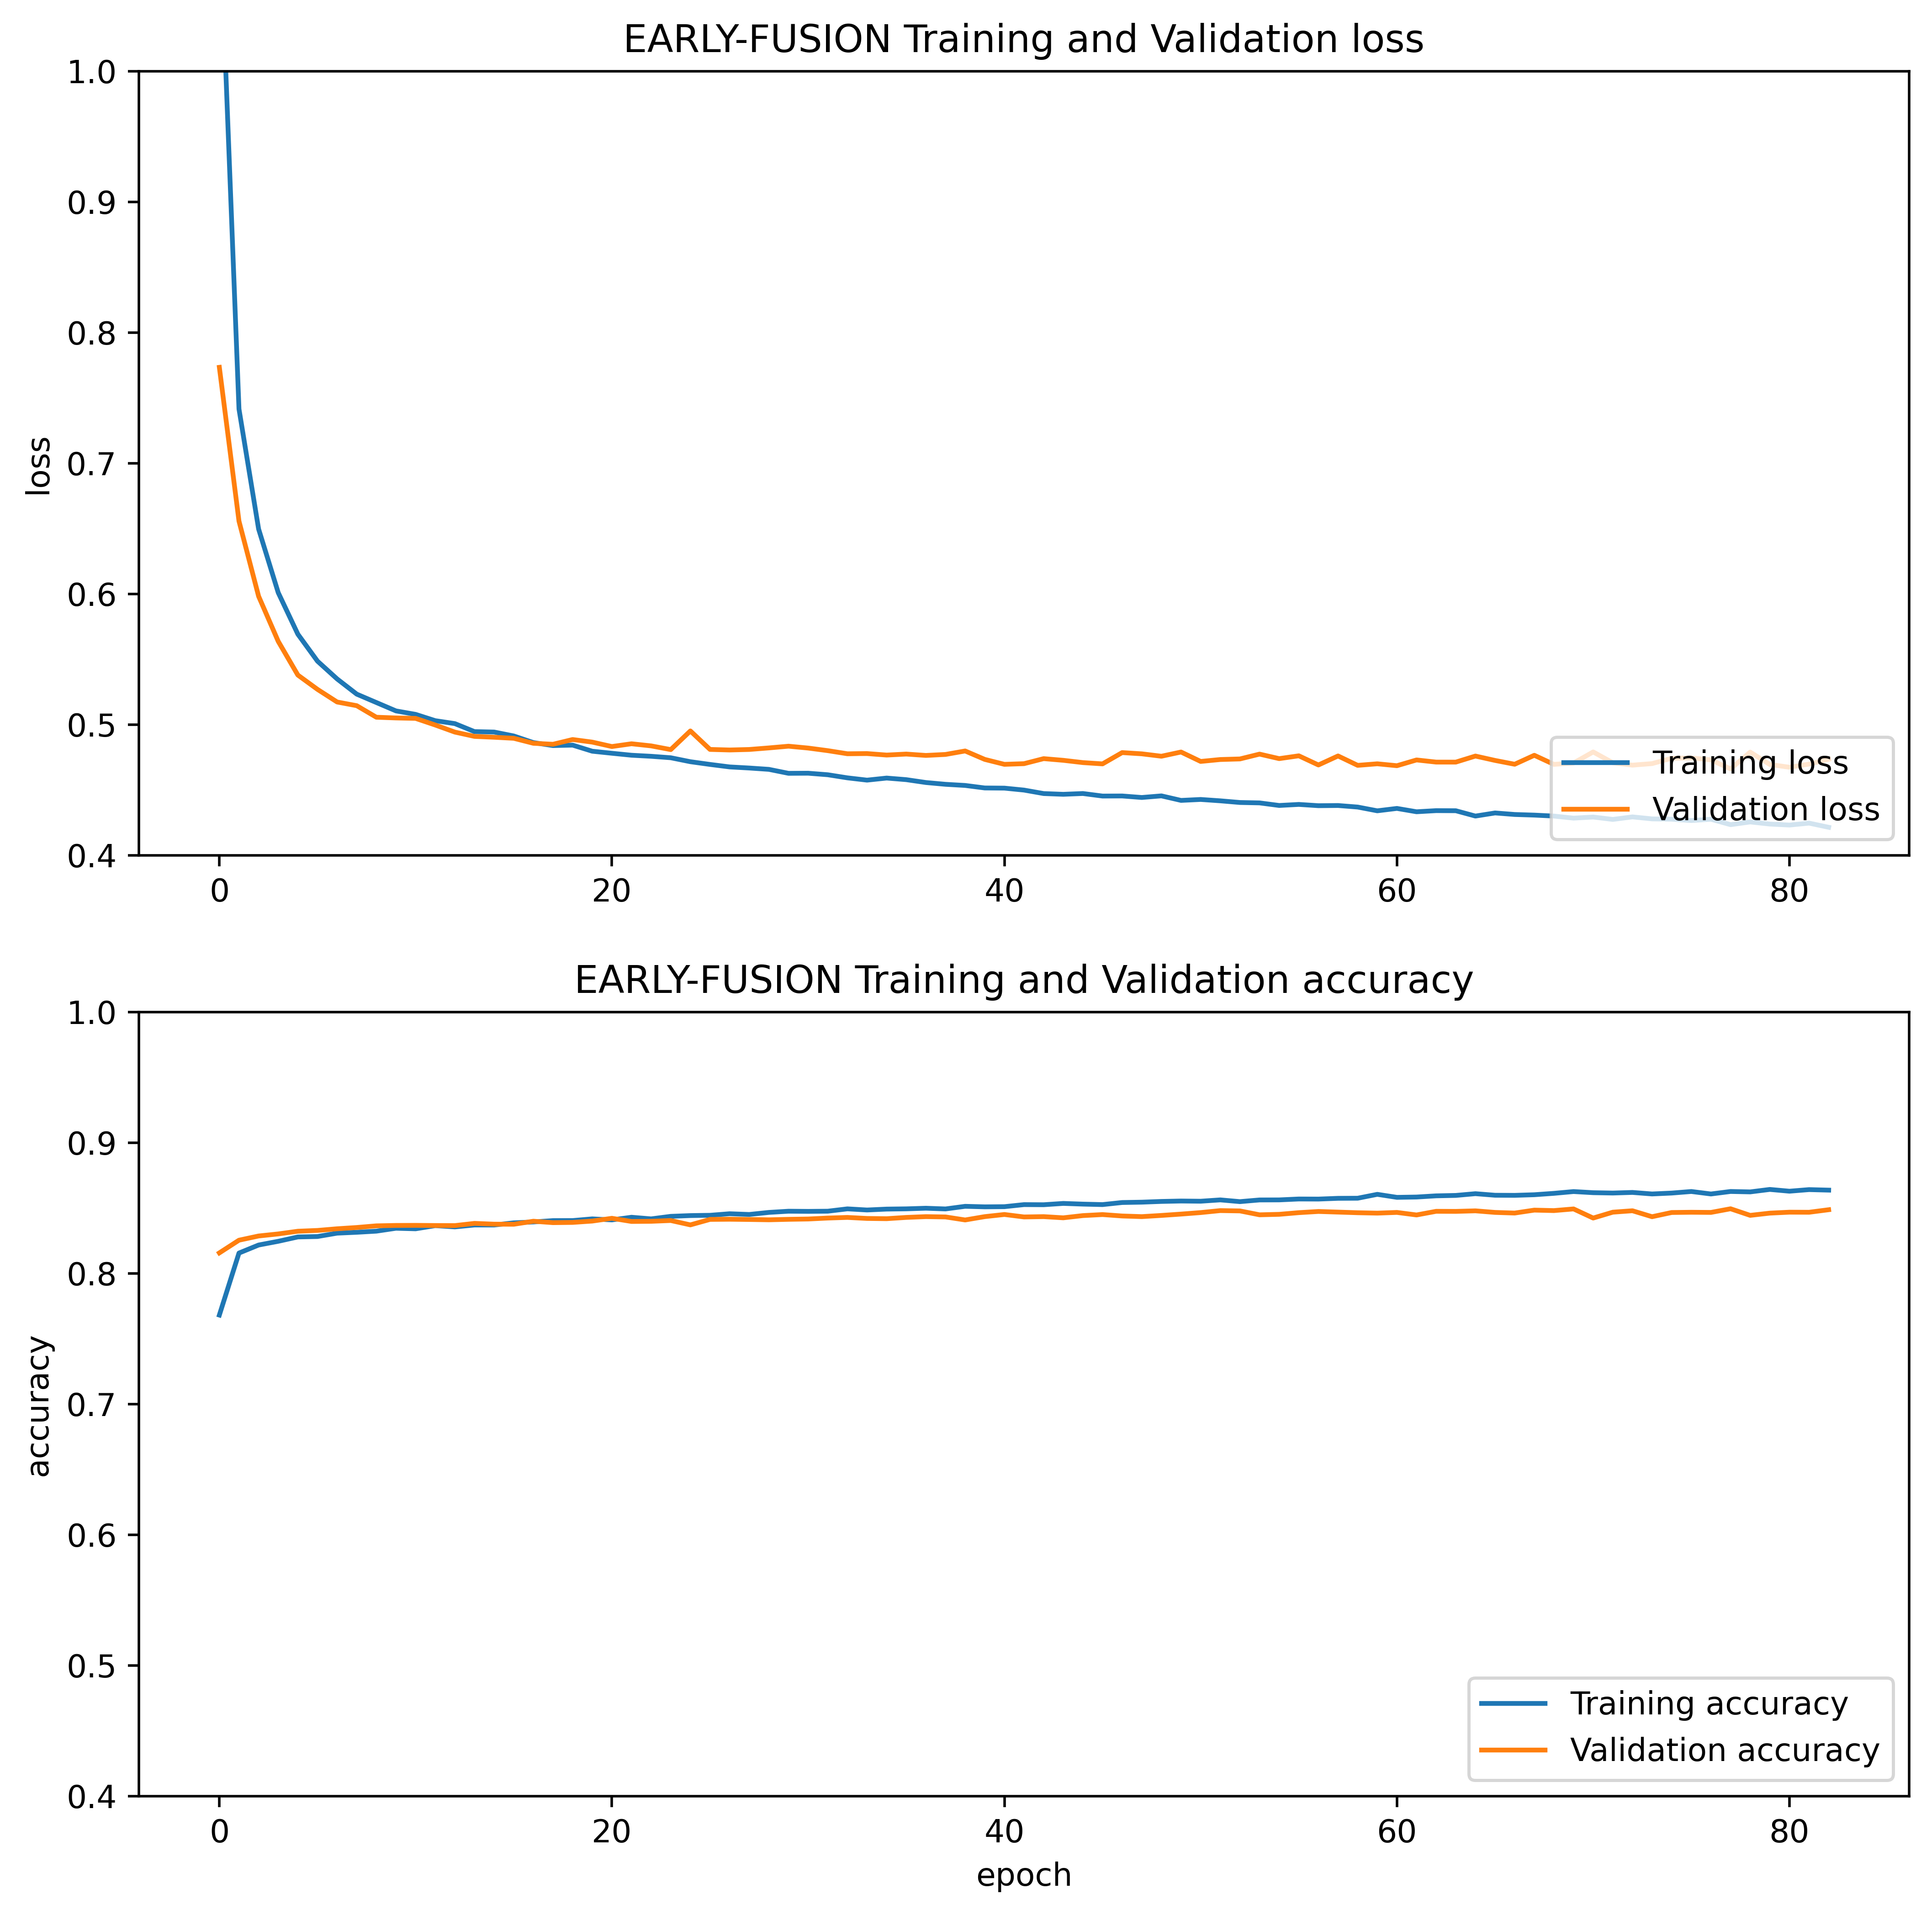

In [21]:
plot_chart(history,name)

In [22]:
y_pred = hypermodel.predict(X_test)

In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [24]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)


for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes

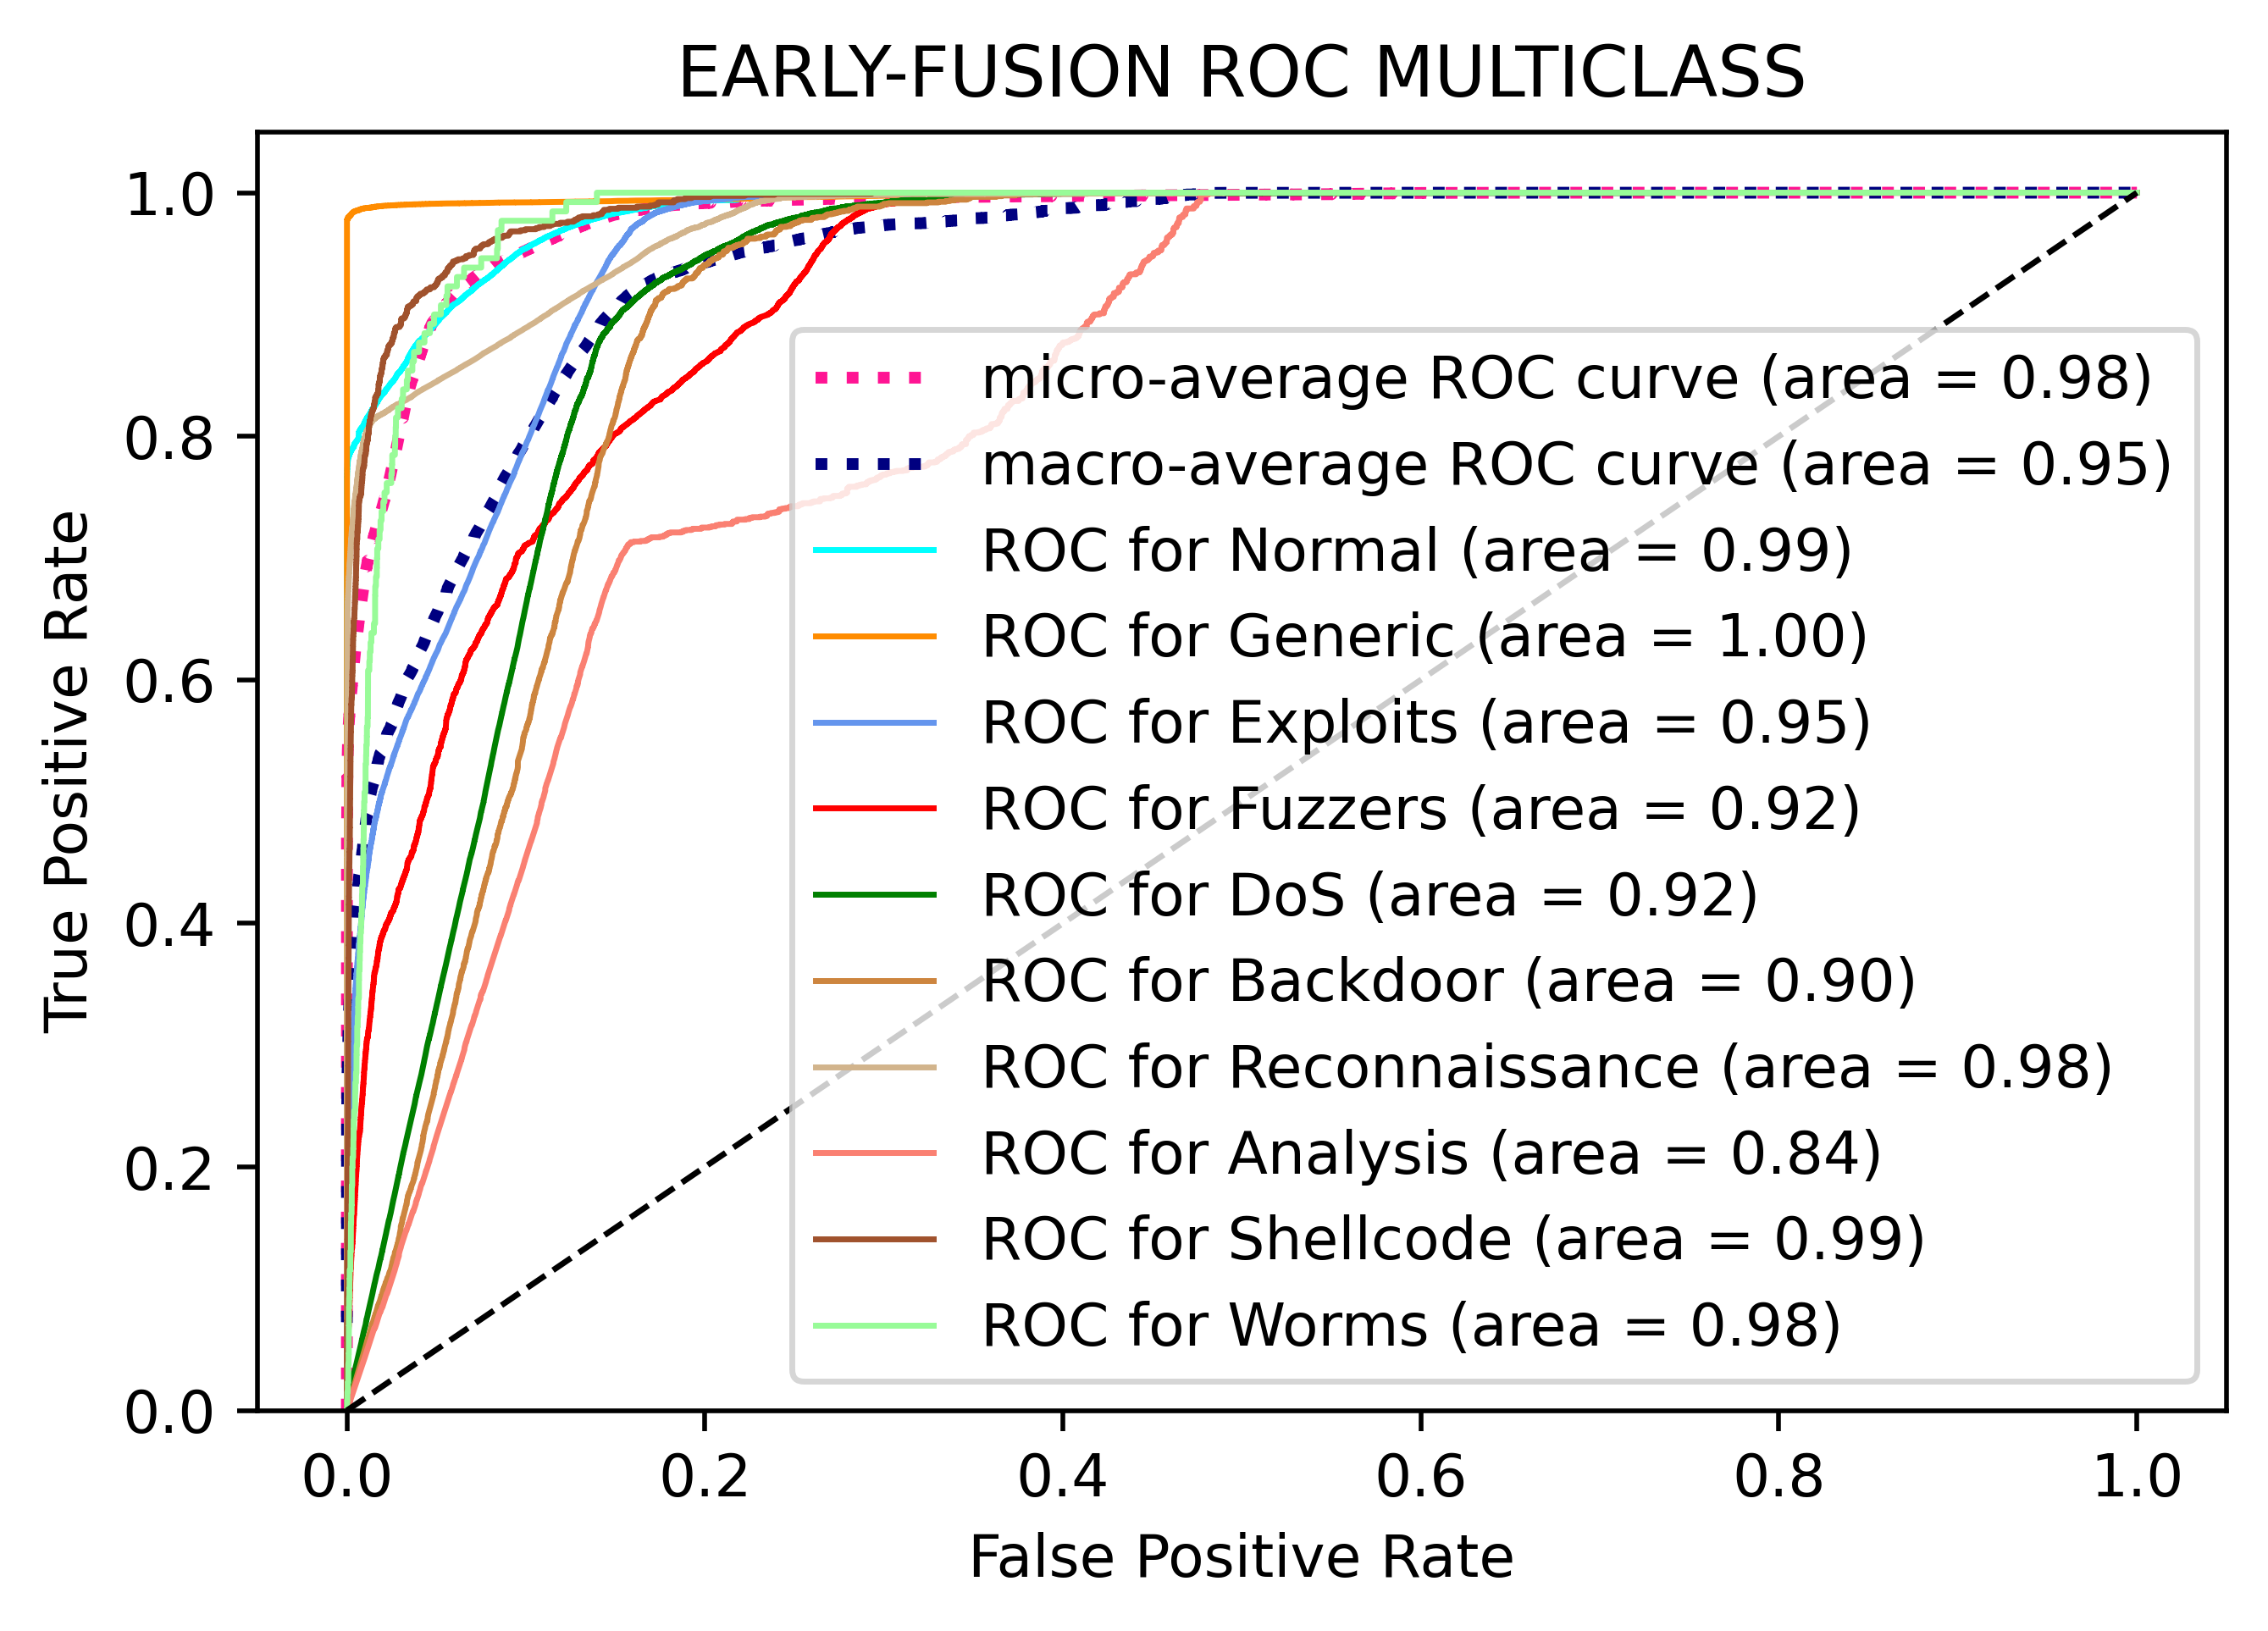

In [25]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=2,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","red","green","peru","tan","salmon","sienna","palegreen"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1,
        label="ROC for {0} (area = {1:0.2f})".format(CLASSES[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EARLY-FUSION ROC MULTICLASS")
plt.legend(loc="lower right")
plt.show()

In [26]:
MODELS_RESULTS

{'EARLY-FUSION': {'train': {'loss': 0.37615275382995605,
   'accuracy': 0.8804979920387268,
   'precision': 0.9497175812721252,
   'recall': 0.8296059966087341,
   'auc': 0.9950552582740784,
   'prc': 0.9658969640731812},
  'validation': {'loss': 0.473356157541275,
   'accuracy': 0.8486670255661011,
   'precision': 0.9175904393196106,
   'recall': 0.7992348074913025,
   'auc': 0.9906063079833984,
   'prc': 0.9447499513626099},
  'test': {'loss': 0.6832242012023926,
   'accuracy': 0.7667573690414429,
   'precision': 0.8634812235832214,
   'recall': 0.7025852203369141,
   'auc': 0.9787706136703491,
   'prc': 0.8901074528694153}}}

In [27]:
pd.DataFrame(MODELS_RESULTS['EARLY-FUSION'])

,train,validation,test
loss,0.376153,0.473356,0.683224
accuracy,0.880498,0.848667,0.766757
precision,0.949718,0.917590,0.863481
recall,0.829606,0.799235,0.702585
auc,0.995055,0.990606,0.978771
prc,0.965897,0.944750,0.890107
